# Double pedulum
![double pendulum](double_pendulum.png){#fig-double-pendulum}

## Introduction

[Double pendulum](https://en.wikipedia.org/wiki/Double_pendulum)

[Mechanical–electrical analogies](https://en.wikipedia.org/wiki/Mechanical%E2%80%93electrical_analogies)

See @Yaren2019

Electrical Equivalent Circuit Based Analysis of Double Pendulum System   
/home/jeff64/Downloads/Electrical Equivalent Circuit Based Analysis of Double Pendulum System.pdf  
<!--
@inproceedings{inproceedings,
author = {Yaren, Tuğçe and Kizir, selçuk and Yildiz, Ali},
year = {2019},
month = {04},
pages = {258-262},
title = {Electrical Equivalent Circuit Based Analysis of Double Pendulum System},
doi = {10.1109/ICEEE2019.2019.00056}
}
-->

## Circuit description

```
* C:\users\jeff64\My Documents\double pendulum\electrical analoge double pendulum with Laplace IC.asc
L1 2 0 10µ Rser=0
L2 3 0 10µ Rser=0
C1 2 1 60µ
C2 3 4 60µ
V1 1 0 0.0313
V2 4 0 0.0104
K1 L1 L2 0.5
.tran 0.01 uic
* Double pendulum
.backanno
.end

```


## Circuit analysis
The circuit analysis follows the steps listed below.

- Draw circuit in LTSpice, export netlist
- Generate network equations
- Symbolic solution
- AC sweep and plot the frequency response at the output
- Transient analysis
  - Generate input signal for transient analysis
  - Mostly following the procedure outlined [here](https://stackoverflow.com/questions/77876224/calculating-inverse-laplace-transform-using-python-or-matlab)
  - display the results

Transient analysis is somewhat more involved than the other types of circuit analysis, primarily because SymPy's inverse Laplace transform is not very robust and can't handle complicated expressions. The output equation needs to be simplified by writing some code to put the equation into forms that SymPy can deal with. 


Analysis not agreeing with LTSpice


Load the following Python modules.

In [1]:
from sympy import *
import numpy as np
from tabulate import tabulate
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import SymMNA
from IPython.display import display, Markdown, Math, Latex
init_printing()

### Load the netlist
The netlist generated by LTSpice 

added voltage sources for IC

In [2]:
net_list = '''
L1 2 0 5e-6
L2 3 0 5e-6
C1 2 1 50e-6
C2 3 4 50e-6
V1 1 0 12
V2 4 0 0
K1 L1 L2 0.5
'''

Generate the network equations.

In [3]:
report, network_df, df2, A, X, Z = SymMNA.smna(net_list)

# Put matricies into SymPy 
X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)

Generate markdown text to display the network equations.

In [4]:
temp = ''
for i in range(len(X)):
    temp += '${:s}$<br>'.format(latex(Eq((A*X)[i:i+1][0],Z[i])))

Markdown(temp)

$C_{1} s v_{1} - C_{1} s v_{2} + I_{V1} = 0$<br>$- C_{1} s v_{1} + C_{1} s v_{2} + I_{L1} = 0$<br>$C_{2} s v_{3} - C_{2} s v_{4} + I_{L2} = 0$<br>$- C_{2} s v_{3} + C_{2} s v_{4} + I_{V2} = 0$<br>$v_{1} = V_{1}$<br>$v_{4} = V_{2}$<br>$- I_{L1} L_{1} s - I_{L2} M_{1} s + v_{2} = 0$<br>$- I_{L1} M_{1} s - I_{L2} L_{2} s + v_{3} = 0$<br>

As shown above MNA generated many equations and these would be difficult to solve by hand. The equations are displade in matrix notation below.

In [5]:
NE_sym

⎡ C₁⋅s⋅v₁ - C₁⋅s⋅v₂ + I_V1  ⎤   ⎡0 ⎤
⎢                           ⎥   ⎢  ⎥
⎢ -C₁⋅s⋅v₁ + C₁⋅s⋅v₂ + I_L1 ⎥   ⎢0 ⎥
⎢                           ⎥   ⎢  ⎥
⎢ C₂⋅s⋅v₃ - C₂⋅s⋅v₄ + I_L2  ⎥   ⎢0 ⎥
⎢                           ⎥   ⎢  ⎥
⎢ -C₂⋅s⋅v₃ + C₂⋅s⋅v₄ + I_V2 ⎥   ⎢0 ⎥
⎢                           ⎥ = ⎢  ⎥
⎢            v₁             ⎥   ⎢V₁⎥
⎢                           ⎥   ⎢  ⎥
⎢            v₄             ⎥   ⎢V₂⎥
⎢                           ⎥   ⎢  ⎥
⎢-I_L1⋅L₁⋅s - I_L2⋅M₁⋅s + v₂⎥   ⎢0 ⎥
⎢                           ⎥   ⎢  ⎥
⎣-I_L1⋅M₁⋅s - I_L2⋅L₂⋅s + v₃⎦   ⎣0 ⎦

The sysmbols generated by the Python code are extraced by the SymPy function free_symbols and then declared as SymPy variables. 

In [6]:
# turn the free symbols into SymPy variables
var(str(NE_sym.free_symbols).replace('{','').replace('}',''))

## Symbolic solution
Since the circuit is not too large, a symbolic solution can be easily obtained.

In [7]:
U_sym = solve(NE_sym,X)

Display the symbolic solution

In [8]:
temp = ''
for i in U_sym.keys():
    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U_sym[i]))

Markdown(temp)

$v_{1} = V_{1}$<br>$v_{2} = \frac{C_{1} C_{2} L_{1} L_{2} V_{1} s^{4} - C_{1} C_{2} M_{1}^{2} V_{1} s^{4} + C_{1} L_{1} V_{1} s^{2} + C_{2} M_{1} V_{2} s^{2}}{C_{1} C_{2} L_{1} L_{2} s^{4} - C_{1} C_{2} M_{1}^{2} s^{4} + C_{1} L_{1} s^{2} + C_{2} L_{2} s^{2} + 1}$<br>$v_{3} = \frac{C_{1} C_{2} L_{1} L_{2} V_{2} s^{4} - C_{1} C_{2} M_{1}^{2} V_{2} s^{4} + C_{1} M_{1} V_{1} s^{2} + C_{2} L_{2} V_{2} s^{2}}{C_{1} C_{2} L_{1} L_{2} s^{4} - C_{1} C_{2} M_{1}^{2} s^{4} + C_{1} L_{1} s^{2} + C_{2} L_{2} s^{2} + 1}$<br>$v_{4} = V_{2}$<br>$I_{V1} = \frac{- C_{1} C_{2} L_{2} V_{1} s^{3} + C_{1} C_{2} M_{1} V_{2} s^{3} - C_{1} V_{1} s}{C_{1} C_{2} L_{1} L_{2} s^{4} - C_{1} C_{2} M_{1}^{2} s^{4} + C_{1} L_{1} s^{2} + C_{2} L_{2} s^{2} + 1}$<br>$I_{V2} = \frac{- C_{1} C_{2} L_{1} V_{2} s^{3} + C_{1} C_{2} M_{1} V_{1} s^{3} - C_{2} V_{2} s}{C_{1} C_{2} L_{1} L_{2} s^{4} - C_{1} C_{2} M_{1}^{2} s^{4} + C_{1} L_{1} s^{2} + C_{2} L_{2} s^{2} + 1}$<br>$I_{L1} = \frac{C_{1} C_{2} L_{2} V_{1} s^{3} - C_{1} C_{2} M_{1} V_{2} s^{3} + C_{1} V_{1} s}{C_{1} C_{2} L_{1} L_{2} s^{4} - C_{1} C_{2} M_{1}^{2} s^{4} + C_{1} L_{1} s^{2} + C_{2} L_{2} s^{2} + 1}$<br>$I_{L2} = \frac{C_{1} C_{2} L_{1} V_{2} s^{3} - C_{1} C_{2} M_{1} V_{1} s^{3} + C_{2} V_{2} s}{C_{1} C_{2} L_{1} L_{2} s^{4} - C_{1} C_{2} M_{1}^{2} s^{4} + C_{1} L_{1} s^{2} + C_{2} L_{2} s^{2} + 1}$<br>

## Initial conditions
The SymPy Heaviside function is used to define the initial current and voltage on the inductor and capacitor.  

Built a dictionary of element values.

In [9]:
element_values = SymMNA.get_part_values(network_df)
element_values

The mutual inductance between L1 and L2 is calculated from the coupling coeeficient.

$M = k\sqrt{L_1L_2}$

In [10]:
K1 = symbols('K1')

# calculate the coupling constant from the mutual inductance
element_values[M1] = element_values[K1]*np.sqrt(element_values[L1] * element_values[L2])
print('mutual inductance, M1 = {:.9f}'.format(element_values[M1]))

mutual inductance, M1 = 0.000002500


In [12]:
t = symbols('t',positive=True)  # t > 0

In [13]:
element_values[V1] = laplace_transform(12*Heaviside(t), t, s)[0]
#element_values[V2] = laplace_transform(0.0104*Heaviside(t), t, s)[0]
NE_ic = NE_sym.subs(element_values)
NE_ic

                                        ⎡0 ⎤
⎡ I_V1 + 5.0e-5⋅s⋅v₁ - 5.0e-5⋅s⋅v₂  ⎤   ⎢  ⎥
⎢                                   ⎥   ⎢0 ⎥
⎢ I_L1 - 5.0e-5⋅s⋅v₁ + 5.0e-5⋅s⋅v₂  ⎥   ⎢  ⎥
⎢                                   ⎥   ⎢0 ⎥
⎢ I_L2 + 5.0e-5⋅s⋅v₃ - 5.0e-5⋅s⋅v₄  ⎥   ⎢  ⎥
⎢                                   ⎥   ⎢0 ⎥
⎢ I_V2 - 5.0e-5⋅s⋅v₃ + 5.0e-5⋅s⋅v₄  ⎥   ⎢  ⎥
⎢                                   ⎥ = ⎢12⎥
⎢                v₁                 ⎥   ⎢──⎥
⎢                                   ⎥   ⎢s ⎥
⎢                v₄                 ⎥   ⎢  ⎥
⎢                                   ⎥   ⎢0 ⎥
⎢-5.0e-6⋅I_L1⋅s - 2.5e-6⋅I_L2⋅s + v₂⎥   ⎢  ⎥
⎢                                   ⎥   ⎢0 ⎥
⎣-2.5e-6⋅I_L1⋅s - 5.0e-6⋅I_L2⋅s + v₃⎦   ⎢  ⎥
                                        ⎣0 ⎦

In [14]:
U_ic = solve(NE_ic,X)

temp = ''
for i in U_ic.keys():
    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U_ic[i]))

Markdown(temp)

$v_{1} = \frac{12.0}{s}$<br>$v_{2} = \frac{36.0 s^{3} + 192000000000.0 s}{3.0 s^{4} + 32000000000.0 s^{2} + 6.4 \cdot 10^{19}}$<br>$v_{3} = \frac{96000000000.0 s}{3.0 s^{4} + 32000000000.0 s^{2} + 6.4 \cdot 10^{19}}$<br>$v_{4} = 0.0$<br>$I_{V1} = \frac{- 9600000.0 s^{2} - 3.84 \cdot 10^{16}}{3.0 s^{4} + 32000000000.0 s^{2} + 6.4 \cdot 10^{19}}$<br>$I_{V2} = \frac{4800000.0 s^{2}}{3.0 s^{4} + 32000000000.0 s^{2} + 6.4 \cdot 10^{19}}$<br>$I_{L1} = \frac{9600000.0 s^{2} + 3.84 \cdot 10^{16}}{3.0 s^{4} + 32000000000.0 s^{2} + 6.4 \cdot 10^{19}}$<br>$I_{L2} = - \frac{4800000.0 s^{2}}{3.0 s^{4} + 32000000000.0 s^{2} + 6.4 \cdot 10^{19}}$<br>

The voltage on node 2 is symplified with the chain of operators applied to the expression; [nsimplify()](https://docs.sympy.org/latest/modules/simplify/simplify.html#sympy.simplify.simplify.nsimplify), [simplify()](https://docs.sympy.org/latest/modules/simplify/simplify.html#simplify), [expand()](https://docs.sympy.org/latest/modules/core.html#sympy.core.function.expand) and [together()](https://docs.sympy.org/latest/modules/polys/reference.html#sympy.polys.rationaltools.together). This helps SymPy solve the inverse Laplace transform.

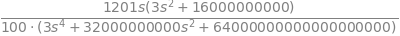

In [203]:
temp_v2a = U_ic[v2].nsimplify().simplify().expand().together()
temp_v2a

In [204]:
node_2a_voltage = inverse_laplace_transform(temp_v2a, s, t)
node_2a_voltage

In [205]:
func_node_2a_voltage = lambdify(t, node_2a_voltage) 

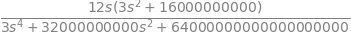

In [152]:
temp_v2 = U_ic[v2].nsimplify().simplify().expand().together()
temp_v2

In [153]:
node_2_voltage = inverse_laplace_transform(temp_v2, s, t)
node_2_voltage

In [154]:
func_node_2_voltage = lambdify(t, node_2_voltage) 

The voltage on node 3 is obtained in a sumular way.

In [163]:
temp_v3 = U_ic[v3].nsimplify().simplify().expand().together()
temp_v3

In [164]:
node_3_voltage = inverse_laplace_transform(temp_v3, s, t)
node_3_voltage

In [165]:
func_node_3_voltage = lambdify(t, node_3_voltage) 

The current in L1 is obtained in a sumular way.

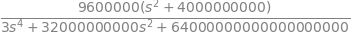

In [168]:
temp = U_ic[I_L1].nsimplify().simplify().expand().together()
temp

In [169]:
L1_current = inverse_laplace_transform(temp, s, t)
L1_current

In [170]:
func_L1_current = lambdify(t, L1_current) 

The current in L2 is obtained in a sumular way.

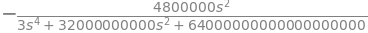

In [180]:
temp = U_ic[I_L2].nsimplify().simplify().expand().together()
temp

In [181]:
L2_current = inverse_laplace_transform(temp, s, t)
L2_current

In [182]:
func_L2_current = lambdify(t, L2_current) 

The plot below shows the node voltages versus time.

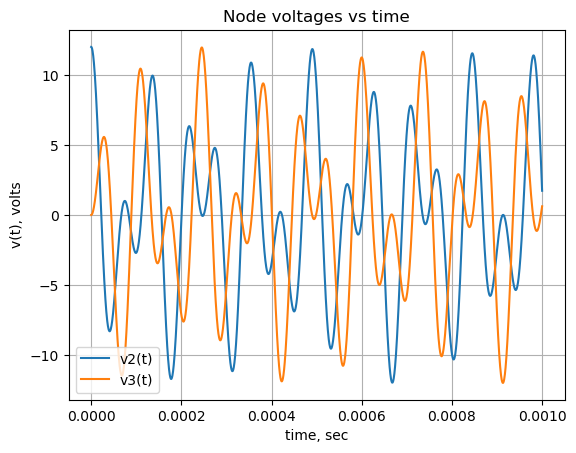

In [212]:
x = np.linspace(0, 0.001, 2000, endpoint=True)

plt.title('Node voltages vs time')

plt.plot(x, func_node_2_voltage(x),label='v2(t)')
plt.plot(x, func_node_3_voltage(x),label='v3(t)')
#plt.plot(x, func_C1_charge(x),label='C1 charge')

#plt.plot(x, func_L1_current(x),label='I_L1(t)')
#plt.plot(x, func_L2_current(x),label='I_L2(t)')

plt.ylabel('v(t), volts')
plt.xlabel('time, sec')

plt.legend()
plt.grid()
plt.show()

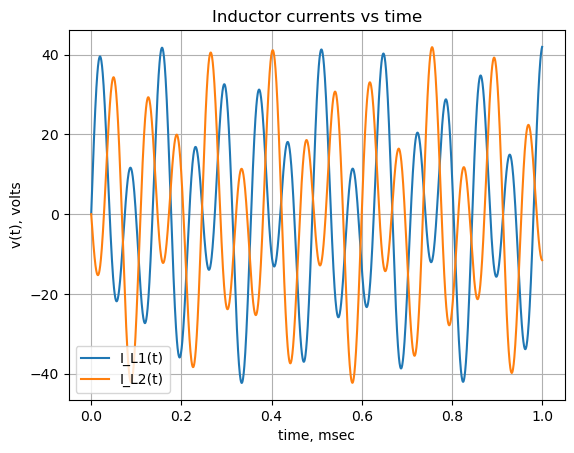

In [213]:
x = np.linspace(0, 0.001, 2000, endpoint=True)

plt.title('Inductor currents vs time')

#plt.plot(x, func_node_2_voltage(x),label='v2(t)')
#plt.plot(x, func_node_3_voltage(x),label='v3(t)')
#plt.plot(x, func_C1_charge(x),label='C1 charge')

plt.plot(x*1e3, func_L1_current(x),label='I_L1(t)')
plt.plot(x*1e3, func_L2_current(x),label='I_L2(t)')

plt.ylabel('v(t), volts')
plt.xlabel('time, msec')

plt.legend()
plt.grid()
plt.show()

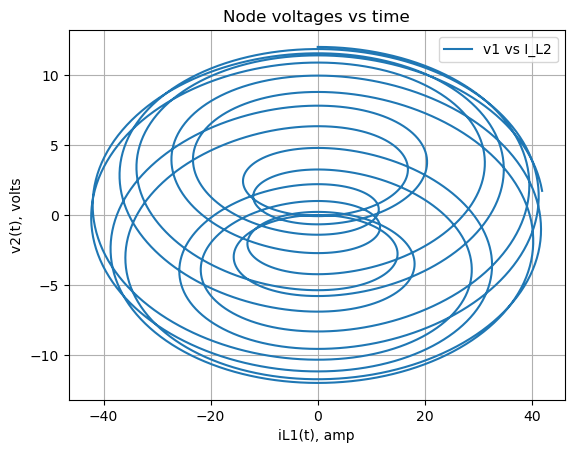

In [192]:
x = np.linspace(0, 0.001, 2000, endpoint=True)

plt.title('Node voltage 2 vs L1 current')

plt.plot(func_L1_current(x), func_node_2_voltage(x), label='v1 vs I_L2')

plt.ylabel('v2(t), volts')
plt.xlabel('iL1(t), amp')

plt.legend()
plt.grid()
plt.show()

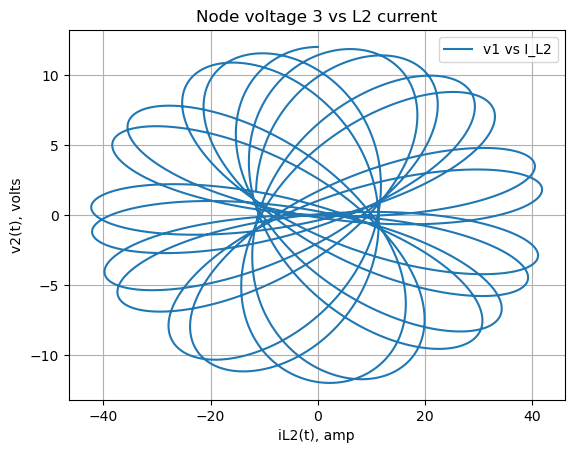

In [214]:
x = np.linspace(0, 0.001, 2000, endpoint=True)

plt.title('Node voltage 3 vs L2 current')

plt.plot(func_L2_current(x), func_node_2_voltage(x),label='v1 vs I_L2')

plt.ylabel('v2(t), volts')
plt.xlabel('iL2(t), amp')

plt.legend()
plt.grid()
plt.show()

## Summary
